In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("CUDA is not availible. Using CPU instead.")

CUDA is not availible. Using CPU instead.


In [5]:
df = pd.read_pickle("C:/Users/kai/Desktop/cdcdata.pkl")

In [6]:
for col in df.columns:
    print(col)

cdc_case_earliest_dt
cdc_report_dt
current_status
sex
age_group
race_ethnicity_combined
hosp_yn
icu_yn
death_yn
medcond_yn
pos_spec_dt
onset_dt


In [7]:
def one_hot_encoding_features(df, columns_to_encode):
  for column in columns_to_encode:
    if column not in df.columns:
      raise ValueError(f"Column '{column}' not found in DataFrame.")
  df_encoded = pd.get_dummies(df, columns=columns_to_encode)

  return df_encoded

columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encoding_features(df, columns_to_encode)

In [8]:
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [9]:
df.head()

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Yes,icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
6,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
11,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
30,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
36,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
40,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [10]:
for col in df.columns:
    print(col)

current_status_Laboratory-confirmed case
current_status_Probable Case
sex_Female
sex_Male
sex_Other
age_group_0 - 9 Years
age_group_10 - 19 Years
age_group_20 - 29 Years
age_group_30 - 39 Years
age_group_40 - 49 Years
age_group_50 - 59 Years
age_group_60 - 69 Years
age_group_70 - 79 Years
age_group_80+ Years
race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic
race_ethnicity_combined_Asian, Non-Hispanic
race_ethnicity_combined_Black, Non-Hispanic
race_ethnicity_combined_Hispanic/Latino
race_ethnicity_combined_Multiple/Other, Non-Hispanic
race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic
race_ethnicity_combined_White, Non-Hispanic
hosp_yn_Yes
icu_yn_Yes
death_yn_Yes
medcond_yn_Yes


0    701401
1     28786
Name: death_yn_Yes, dtype: int64
0    0.960577
1    0.039423
Name: death_yn_Yes, dtype: float64


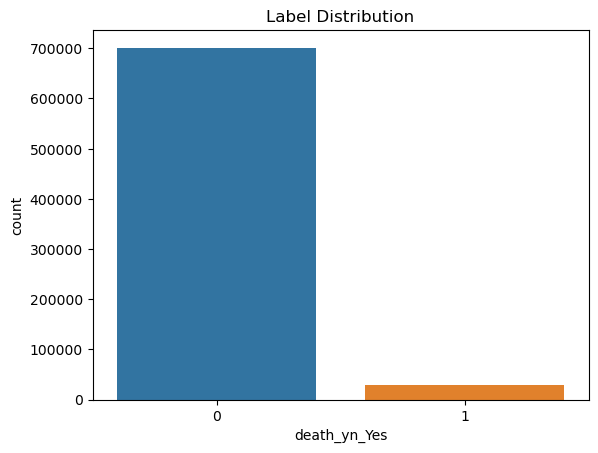

In [11]:
label_counts = df['death_yn_Yes'].value_counts()
print(label_counts)

label_proportions = label_counts / len(df)
print(label_proportions)

sns.countplot(x=df['death_yn_Yes'])
plt.title('Label Distribution')
plt.show()

In [12]:
##Proportion of each feature that is null.
df.isnull().sum()

current_status_Laboratory-confirmed case                                        0
current_status_Probable Case                                                    0
sex_Female                                                                      0
sex_Male                                                                        0
sex_Other                                                                       0
age_group_0 - 9 Years                                                           0
age_group_10 - 19 Years                                                         0
age_group_20 - 29 Years                                                         0
age_group_30 - 39 Years                                                         0
age_group_40 - 49 Years                                                         0
age_group_50 - 59 Years                                                         0
age_group_60 - 69 Years                                                         0
age_group_70 - 7

In [13]:
df.shape

(730187, 25)

In [14]:
features = df.drop('death_yn_Yes', axis = 1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [15]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X,y,test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [16]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

# Fit the model on training data
rf_classifier.fit(X_train, y_train)

# Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

# Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

[[1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [9.99751555e-01 2.48445325e-04]
 ...
 [1.00000000e+00 0.00000000e+00]
 [9.99716138e-01 2.83862482e-04]
 [9.99778978e-01 2.21022226e-04]]
[[9.80986310e-01 1.90136896e-02]
 [1.00000000e+00 0.00000000e+00]
 [9.42691284e-01 5.73087162e-02]
 ...
 [9.99690475e-01 3.09524536e-04]
 [9.99299526e-01 7.00474215e-04]
 [9.99929639e-01 7.03606169e-05]]


In [41]:
# Predict probabilities on validation data
y_pred_proba_val = rf_classifier.predict_proba(X_val)

# Predict probabilities on testing data
y_pred_proba_test = rf_classifier.predict_proba(X_test)

# Extract the predicted probability of the positive class (death) for validation and testing data
positive_class_index = 1  # Assuming '1' is the positive class index
death_probabilities_val = y_pred_proba_val[:, positive_class_index]
death_probabilities_test = y_pred_proba_test[:, positive_class_index]

# Initialize an empty dictionary to store average probabilities for each feature
average_probabilities_by_feature = {}

# Iterate over each feature
for feature_name in features.columns:
    # Get the feature values for validation and testing data
    feature_values_val = X_val[:, features.columns.get_loc(feature_name)]
    feature_values_test = X_test[:, features.columns.get_loc(feature_name)]
    
    # Calculate the average probability of death for each feature value
    feature_probabilities_val = []
    feature_probabilities_test = []
    for value in np.unique(feature_values_val):
        # Select samples with the current feature value
        val_indices = np.where(feature_values_val == value)[0]
        test_indices = np.where(feature_values_test == value)[0]
        
        # Calculate the average probability of death for the current feature value
        average_probability_val = np.mean(death_probabilities_val[val_indices])
        average_probability_test = np.mean(death_probabilities_test[test_indices])
        
        # Store the average probability for the current feature value
        feature_probabilities_val.append(average_probability_val)
        feature_probabilities_test.append(average_probability_test)
    
    # Store the average probabilities for the current feature
    average_probabilities_by_feature[feature_name] = {
        'Average Probability of Death (Validation)': feature_probabilities_val,
        'Average Probability of Death (Testing)': feature_probabilities_test
    }

# Create a DataFrame to store average probabilities for each feature
average_probabilities_df = pd.DataFrame(average_probabilities_by_feature)

# Print the DataFrame
print(average_probabilities_df)


# # Convert features to DataFrame
# features_df = pd.DataFrame(data=X, columns=features.columns)

# # Iterate over each feature
# for feature_name in features_df.columns:
#     # Get the feature values for validation and testing data
#     feature_values_val = X_val[:, features_df.columns.get_loc(feature_name)]
#     feature_values_test = X_test[:, features_df.columns.get_loc(feature_name)]
    
#     # Create DataFrames with feature values and corresponding probabilities for validation and testing data
#     feature_probabilities_val_df = pd.DataFrame({
#         'Feature Value': feature_values_val,
#         'Probability of Death (Validation)': death_probabilities_val
#     })
#     feature_probabilities_test_df = pd.DataFrame({
#         'Feature Value': feature_values_test,
#         'Probability of Death (Testing)': death_probabilities_test
#     })
    
#     # Print the feature name
#     print("Feature:", feature_name)
    
#     # Print the DataFrame for validation data
#     print("Validation Data:")
#     print(feature_probabilities_val_df)
#     print("\n")
    
#     # Print the DataFrame for testing data
#     print("Testing Data:")
#     print(feature_probabilities_test_df)
#     print("\n")

                                              current_status_Laboratory-confirmed case  \
Average Probability of Death (Validation)   [0.01611138544944043, 0.04205099709000362]   
Average Probability of Death (Testing)     [0.01662139813731705, 0.042465928568391965]   

                                                          current_status_Probable Case  \
Average Probability of Death (Validation)   [0.04205099709000362, 0.01611138544944043]   
Average Probability of Death (Testing)     [0.042465928568391965, 0.01662139813731705]   

                                                                            sex_Female  \
Average Probability of Death (Validation)  [0.039083937852960916, 0.03949201753660917]   
Average Probability of Death (Testing)        [0.039965221372892, 0.03943451005203446]   

                                                                               sex_Male  \
Average Probability of Death (Validation)   [0.03949201753660917, 0.039083937852960916]   
Avera

In [39]:
# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.9668031608211561
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     70220
         1.0       0.59      0.43      0.50      2799

    accuracy                           0.97     73019
   macro avg       0.79      0.71      0.74     73019
weighted avg       0.96      0.97      0.96     73019

Testing Accuracy: 0.967843985811912
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     70220
         1.0       0.04      0.03      0.04      2799

    accuracy                           0.94     73019
   macro avg       0.50      0.50      0.50     73019
weighted avg       0.93      0.94      0.93     73019



In [38]:
# Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

#Function to plot ROC Curve
def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

#Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    plt.figure()
    plt.step(recall, precision, where='post', label='Precision-Recall curve (area = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.legend(loc="lower left")
    plt.show()

#Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

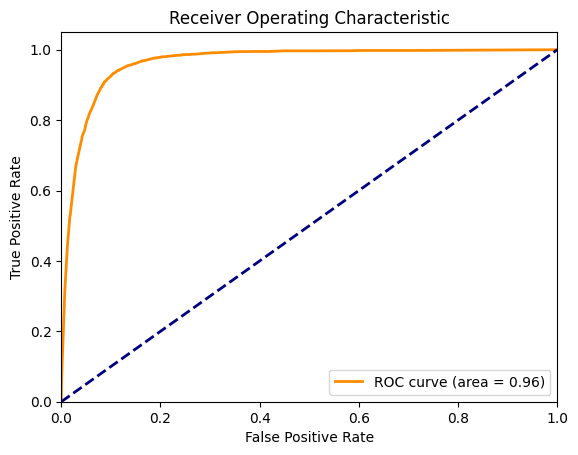

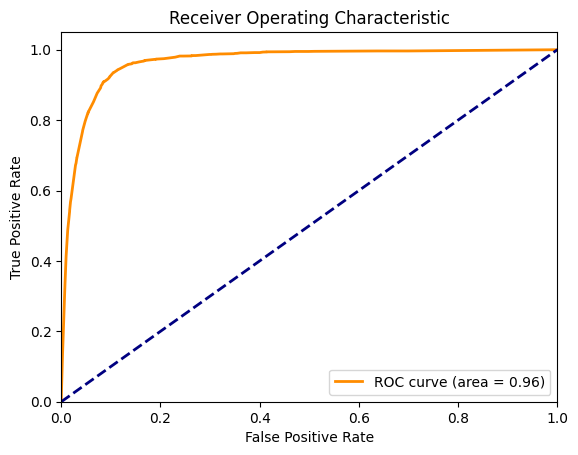

In [19]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val)

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test)

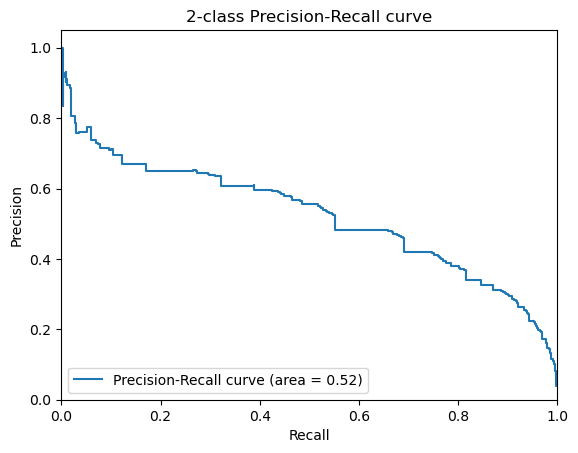

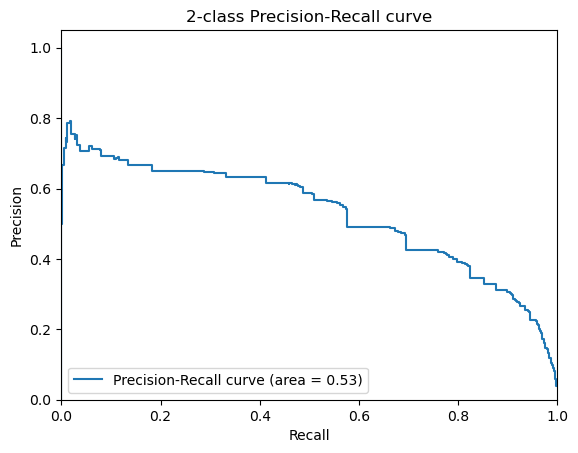

In [21]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val)

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test)

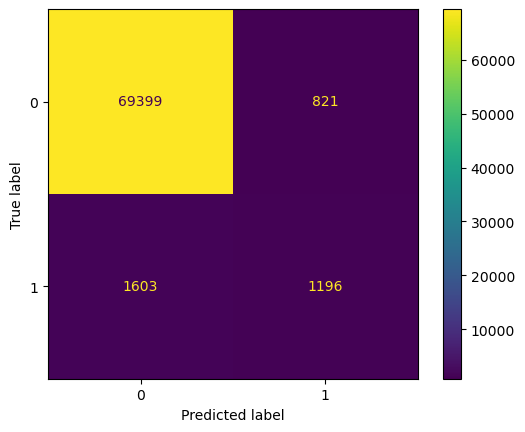

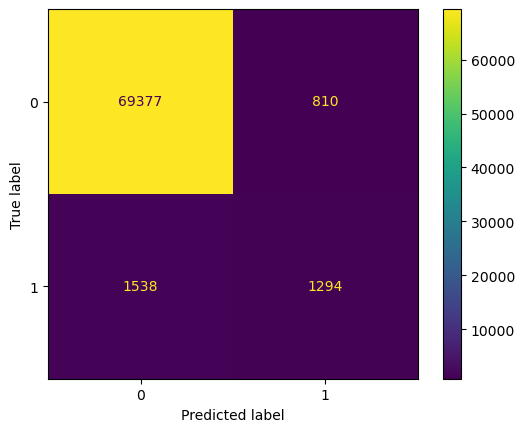

In [22]:
#Plot Confusion Matrix for validation set
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
plot_confusion_matrix(y_test, y_pred_test)

In [22]:
pip install shap

In [23]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Yes', 'icu_yn_Yes', 'medcond_yn_Yes']

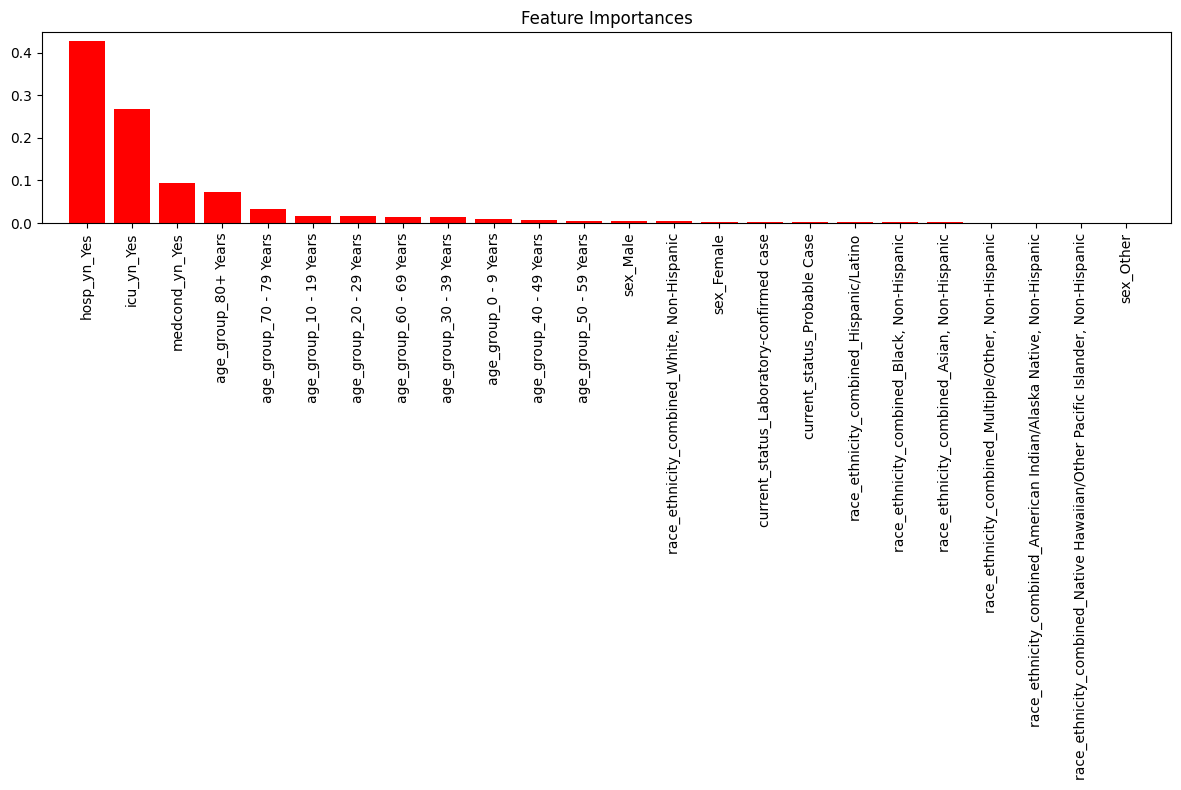

In [24]:
import shap

#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [37]:
import time
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 202.805 seconds


<ipython-input-38-2e3807852b03>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


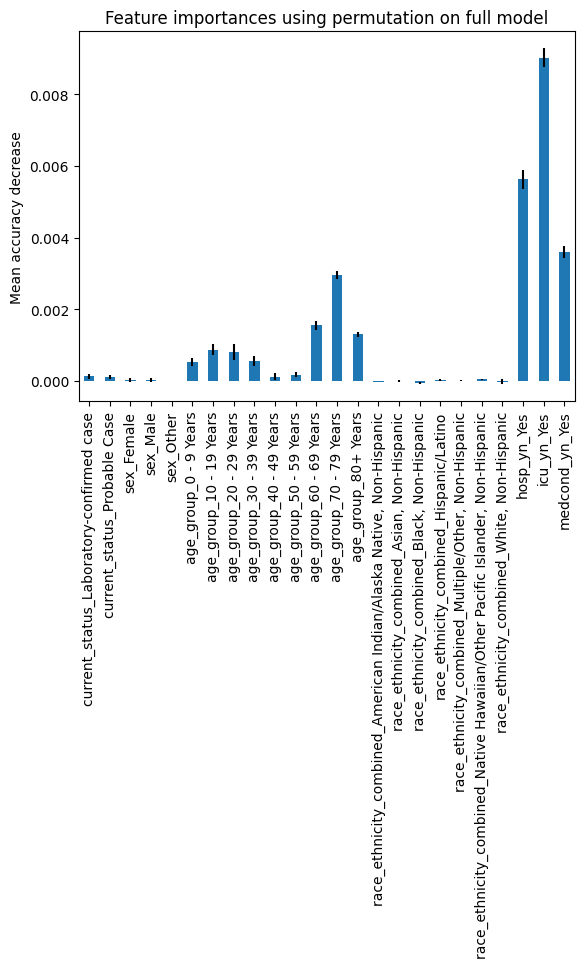

In [38]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [25]:
explainer = shap.TreeExplainer(rf_classifier)
#Too large
#shap_values = explainer.shap_values(X_train)

X_sample = shap.sample(X_train, 100)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (100, 24, 2)
X_train shape: (584149, 24)


 The calculation of SHAP values is done by comparing the prediction of the model with and without the feature in every possible way of adding the feature to the model.The color of the dot represents the value of the feature and the X-axis depicts the direction and magnitude of the impact. Red colored dots represent high value of the feature and the blue represents lower value. A positive SHAP value means the feature value increases likelihood of COVID-19 mortality. For features with positive SHAP value for red dots, suggests directly proportional variable to outcome of interest and those with positive SHAP value for blue dots, suggest inverse correlation.

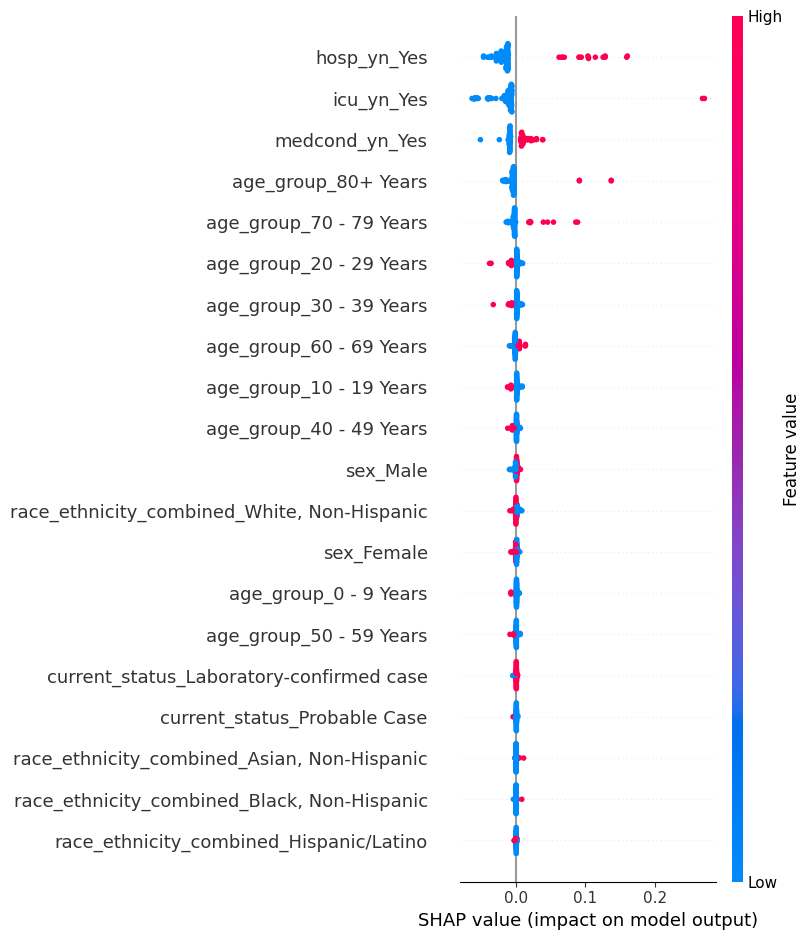

In [26]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

In [27]:
class RandomForestModel(nn.Module):
    def __init__(self, n_estimators=100):
        super(RandomForestModel, self).__init__()
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    def forward(self, x):
        x = x.cpu().numpy()  # Convert to numpy array as sklearn requires numpy array
        return torch.from_numpy(self.model.predict_proba(x)[:, 1]).float().to(device)

In [28]:
rf_model = RandomForestModel().to(device)

In [33]:
def train_model(model, full_loader, num_epochs=10):
        # Non-neural network models (fit once)
        inputs, labels = next(iter(full_loader))  # Get all data in a single batch
        model.model.fit(inputs.cpu().numpy(), labels.cpu().numpy())
        print(f'Trained {type(model.model).__name__} with full dataset')

In [34]:
def evaluate_model(model, data_loader):
    model.eval()
    total_predictions, correct_predictions = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            predicted = outputs.round()
            correct_predictions += (predicted == labels.to(device)).sum().item()
            total_predictions += labels.size(0)
    return correct_predictions / total_predictions

In [36]:
# Training all models
models = [rf_model]
model_names = ['Random Forest']
for model, name in zip(models, model_names):
    print(f'\nTraining {name}...')
    train_model(model, train_loader)
    val_accuracy = evaluate_model(model, val_loader)
    test_accuracy = evaluate_model(model, test_loader)
    print(f'{name} - Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


Training Random Forest...
Trained RandomForestClassifier with full dataset
Random Forest - Validation Accuracy: 0.9618, Test Accuracy: 0.9612
